<center>
    <h2>Это - вторая часть проекта. В этом блокноте представлено всё о проверке гипотез и машинном обучении :)</h2>
</center>

In [1]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

## 3. Гипотезы

__Основная гипотеза, которую я тут буду проверять - среднее количество ДТП за лето больше, чем за все остальные времена года (не вместе взятые, очевидно). Также было бы славно посмотреть, зависит ли количество ДТП от погодных условий, времени суток и магистрали (если произошло на магистрали). Учитывая, сколько тут категориальных признаков, проверять можно хоть до осени, но по моему мнению, эти гипотезы имеют хоть какое-то логическое обоснование. Сейчас будем обследовать данные и составлять итоговый список гипотез, так как обилие категориальных признаков может помешать проверке__

__Для начала нарисуем несколько графиков и глянем на распределения данных__

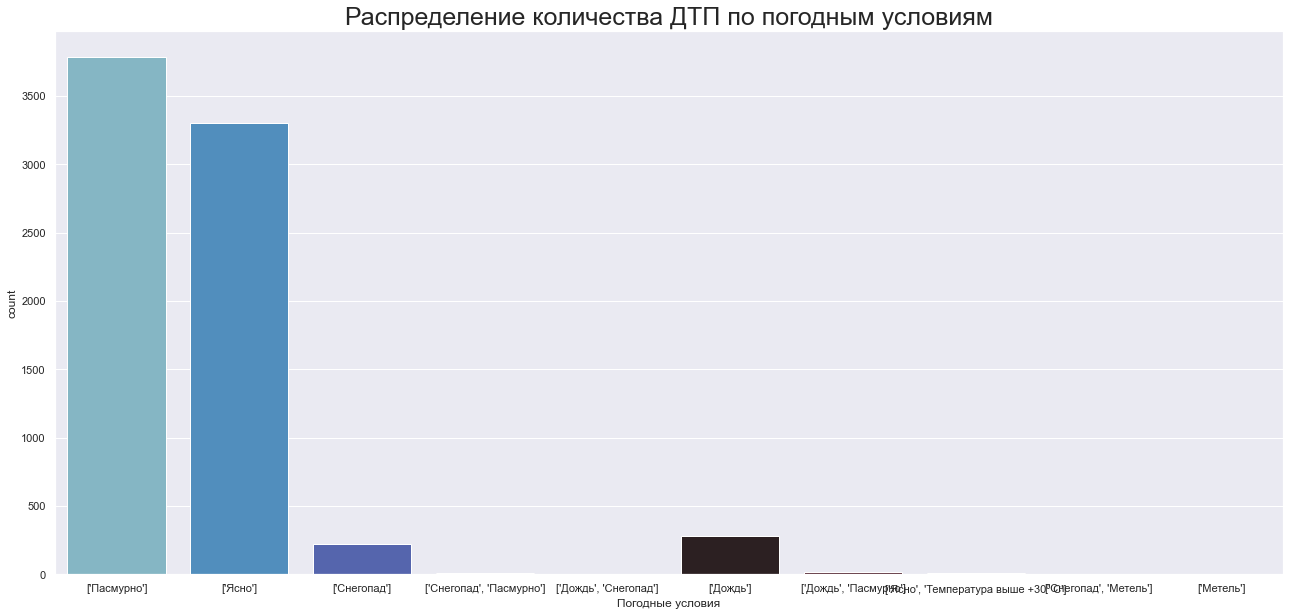

In [141]:
sns.countplot(df['Погодные условия'], palette='icefire').set_title('Распределение количества ДТП по погодным условиям', fontdict={'size': 25});

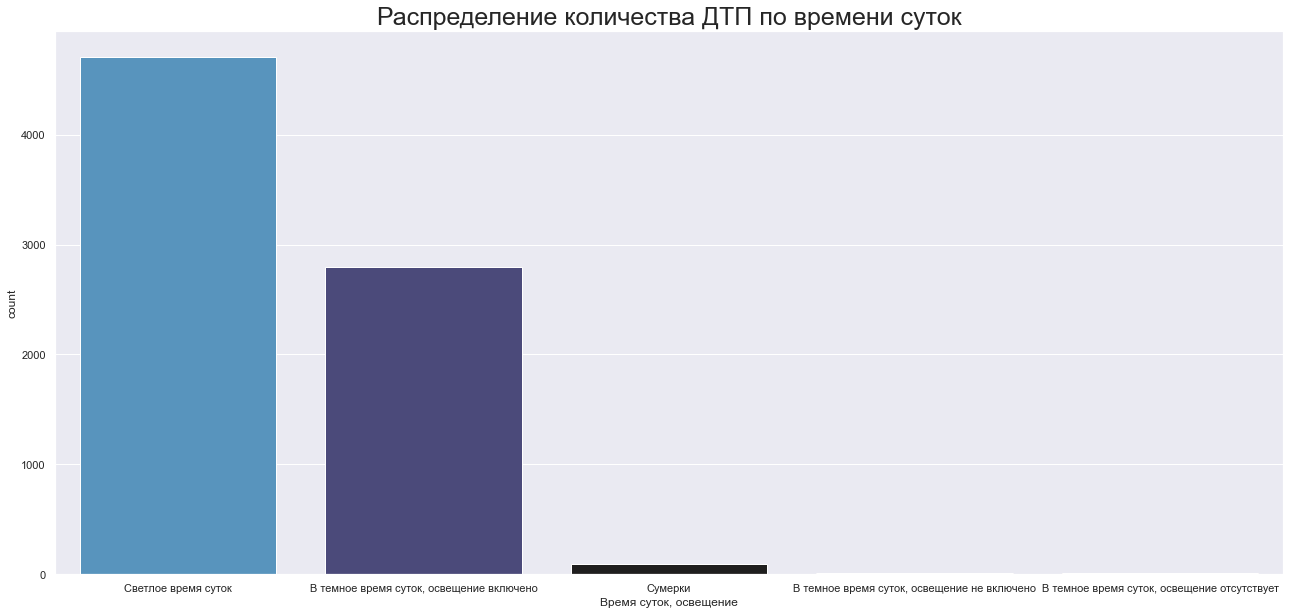

In [143]:
sns.countplot(df['Время суток, освещение'], palette='icefire').set_title('Распределение количества ДТП по времени суток', fontdict={'size': 25});

__Штош. Погодные условия и время суток отлетают сразу же, имеем два самых популярных (и максимально очевидных кейса) и кучку выбросов в минимальную сторону, которая составляет остальные кейсы. Кажется, ничего интересного тут проверить не удастся__

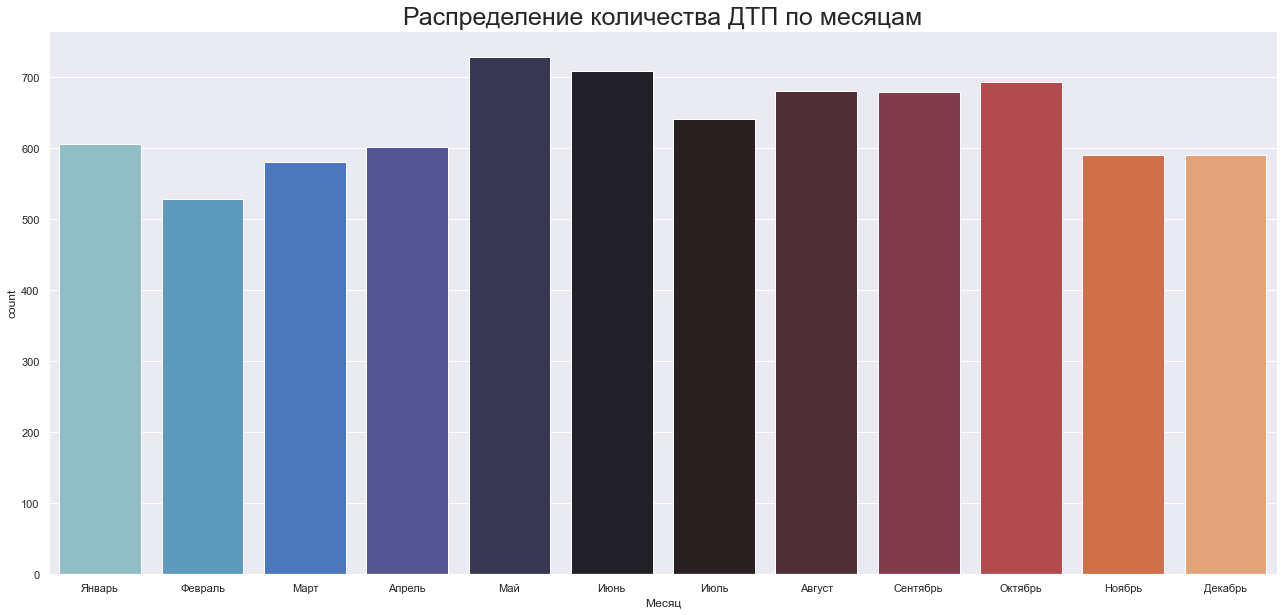

In [144]:
sns.countplot(df['Месяц'], palette='icefire').set_title('Распределение количества ДТП по месяцам', fontdict={'size': 25});

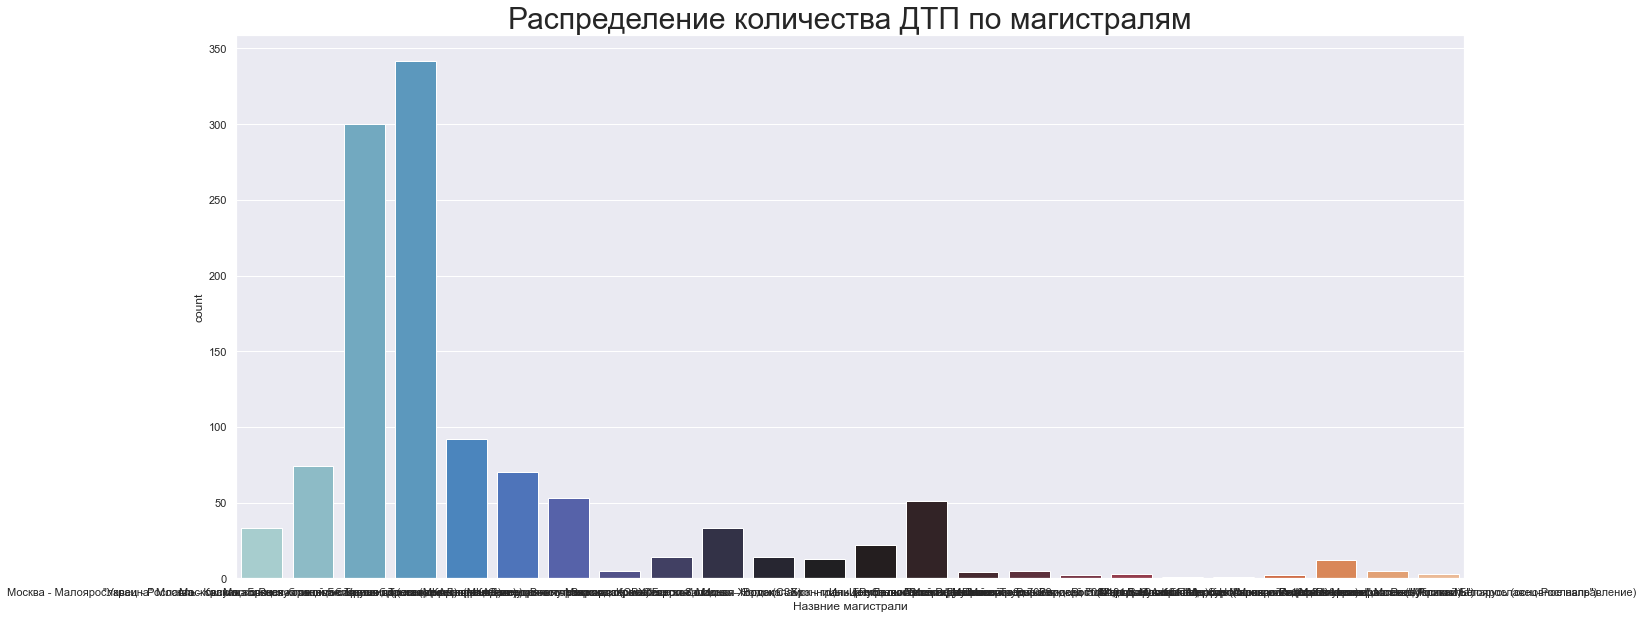

In [145]:
sns.countplot(df['Назвние магистрали'], palette='icefire').set_title('Распределение количества ДТП по магистралям', fontdict={'size': 30});

__А вот тут уже лучше. Распределение по месяцам напоминает нормальное, так что там проверяем вообще спокойно__

__Распрделение по магистралям, выглядит довольно по-уродски, так как имеет два аномально больших значения (спойлер: внешняя и внутренняя сторона МКАД) и длиннющие хвосты из маленьких, что не позволяет нормально попроверять всякое__

__Итак, берём распределение по месяцам и, неожиданно, первой гипотезой оказывается гипотеза о его нормальности:__

$$
\begin{aligned}
& H_0: F_x  : {нормально} \\
\end{aligned}
$$


In [147]:
sts.normaltest(df['Месяц'].value_counts())

NormaltestResult(statistic=0.8235642427801283, pvalue=0.6624685980664842)

__Нормалтест выдал p-value 0.66, спокойно работаем, как с нормальным (выборка огромная, поэтому использовалась функция с тестом Д`Агостино-Пирсона)__

__Надо создать новый столбец с временами года (зима, весна, лето, осень), будем с ними работать (значения буду получены путем сложения количества ДТП за каждые 3 месяца, поэтому нормальность сохранится, так линейная комбинация нормальных величин тоже нормальна__

In [148]:
season = []
for i in range(len(df['Месяц'])):
    if df['Месяц'][i] in ['Декабрь', 'Январь', 'Февраль']:
        season.append('Зима')
    elif df['Месяц'][i] in ['Март', 'Апрель', 'Май']:
        season.append('Весна')
    elif df['Месяц'][i] in ['Июнь', 'Июль', 'Август']:
        season.append('Лето')
    elif df['Месяц'][i] in ['Сентябрь', 'Октябрь', 'Ноябрь']:
        season.append('Осень')
df['Время года'] = season
df['Время года']

0       Зима
1       Зима
2       Зима
3       Зима
4       Зима
        ... 
7624    Зима
7625    Зима
7626    Зима
7627    Зима
7628    Зима
Name: Время года, Length: 7629, dtype: object

In [154]:
df['Время года'].value_counts()

Лето     2030
Осень    1963
Весна    1911
Зима     1725
Name: Время года, dtype: int64

In [180]:
mean = df.groupby(by='Время года').mean()
var = df.groupby(by='Время года').var(ddof=1)

nx = len(df[df['Время года'] == 'Лето'])
ny = len(df[df['Время года'] == 'Зима'])
ny1 = len(df[df['Время года'] == 'Весна'])
ny2 = len(df[df['Время года'] == 'Осень'])

mean_x = mean.loc['Лето', 'Кол-во ТС']
mean_y = mean.loc['Зима', 'Кол-во ТС']
mean_y1 = mean.loc['Весна', 'Кол-во ТС']
mean_y2 = mean.loc['Осень', 'Кол-во ТС']

var_x = var.loc['Лето', 'Кол-во ТС']
var_y = var.loc['Зима', 'Кол-во ТС']
var_y1 = var.loc['Весна', 'Кол-во ТС']
var_y2 = var.loc['Осень', 'Кол-во ТС']

__Гипотеза 1: матожидание количества ДТП летом равно матожиданию количества ДТП зимой (вообще, количеству транспортных средств, но у нас нет массовых ДТП, поэтому по результататм для количества транспортных средств можно, я полагаю, сделать выводы для количества ДТП в целом__

$$
\begin{aligned}
& H_0: \mu_{summer} = \mu_{winter} \\
& H_1: \mu_{summer} > \mu_{winter}
\end{aligned}
$$


In [182]:
var_delta = (var_x * (nx - 1) + var_y * (ny - 1)) / (nx + ny - 2)
tt = (mean_x - mean_y) / np.sqrt(var_delta * ((1 / nx) + (1 / ny)))
tc  = sts.t.ppf(0.95, nx + ny - 2) 
print('t расчётная:', tt)
print('t критическая:', tc)
print('t расчётная больше t критической => нулевая гипотеза отвергается')

t расчётная: 2.2815963676912063
t критическая: 1.645259741429339
t расчётная больше t критической => нулевая гипотеза отвергается


__Гипотеза 2: матожидание количества ДТП летом равно матожиданию количества ДТП весной__

$$
\begin{aligned}
& H_0: \mu_{summer} = \mu_{spring} \\
& H_1: \mu_{summer} > \mu_{spring}
\end{aligned}
$$


In [184]:
var_delta1 = (var_x * (nx - 1) + var_y1 * (ny1 - 1)) / (nx + ny1 - 2)
tt1 = (mean_x - mean_y1) / np.sqrt(var_delta1 * ((1 / nx) + (1 / ny1)))
tc1  = sts.t.ppf(0.95, nx + ny1 - 2) 
print('t расчётная:', tt1)
print('t критическая:', tc1)
print('t расчётная больше t критической => нулевая гипотеза отвергается')

t расчётная: 3.8609772246623826
t критическая: 1.6452405601223419
t расчётная больше t критической => нулевая гипотеза отвергается


__Гипотеза 3: матожидание количества ДТП летом равно матожиданию количества ДТП осенью__

$$
\begin{aligned}
& H_0: \mu_{summer} = \mu_{autumn} \\
& H_1: \mu_{summer} > \mu_{autumn}
\end{aligned}
$$


In [185]:
var_delta2 = (var_x * (nx - 1) + var_y2 * (ny2 - 1)) / (nx + ny2 - 2)
tt2 = (mean_x - mean_y2) / np.sqrt(var_delta2 * ((1 / nx) + (1 / ny2)))
tc2  = sts.t.ppf(0.95, nx + ny2 - 2) 
print('t расчётная:', tt2)
print('t критическая:', tc2)
print('t расчётная больше t критической => нулевая гипотеза отвергается')

t расчётная: 3.9272408449595186
t критическая: 1.6452355174703164
t расчётная больше t критической => нулевая гипотеза отвергается


__Итак, все три гипотезы были отвергнуты в пользу альтернативы. Есть все основания полагать, что мы были правы - в среднем летом ДТП происходит больше, чем в остальные времена года__

# 4. Машинное обучение

__Будем, очевидно, фигачить классификацию. Попробуем обучить парочку моделей, предсказывающих вероятность ДТП с погибшими, обучать будем, соответственно, старый добрый логрег__

In [192]:
len(df[df['Погибло'] != 0])

278

In [193]:
len(df[df['Погибло'] == 0])

7351

__Налицо очень сильный дисбаланс между классами__

In [213]:
df

,Дата,Время,Вид ДТП,Кол-во ТС,Погибло,Погибло детей,Ранено,Ранено деетй,Округ,Район,...,Погодные условия,Транспортные недостатки,Факторы,ТС 1,ТС 2,ТС 3,День недели,Месяц,Время года,Нерабочий день
0,2022-01-01,2023-06-14 09:05:00,Столкновение,2,0,0,2,0,Северный АО,Сокол,...,['Пасмурно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Легковой,Спец.техника,NaN,Суббота,Январь,Зима,0
1,2022-01-01,2023-06-14 07:30:00,Наезд на препятствие,1,0,0,1,0,Северный АО,Ховрино,...,['Пасмурно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Легковой,NaN,NaN,Суббота,Январь,Зима,0
2,2022-01-01,2023-06-14 13:41:00,Наезд на стоящее ТС,3,0,0,1,0,Троицкий и Новомосковский АО,Десеновский,...,['Пасмурно'],['Отсутствие перечисленных недостатков транспо...,'Режим движения нарушен вследствие ранее произ...,Легковой,Легковой,Легковой,Суббота,Январь,Зима,0
3,2022-01-01,2023-06-14 12:10:00,Столкновение,2,0,0,1,0,Северо-Западный АО,Митино,...,['Ясно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Автобус,Легковой,NaN,Суббота,Январь,Зима,0
4,2022-01-01,2023-06-14 21:50:00,Столкновение,2,0,0,1,0,Троицкий и Новомосковский АО,Московский,...,['Снегопад'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Легковой,Легковой,NaN,Суббота,Январь,Зима,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7624,2022-12-28,2023-06-14 21:00:00,Столкновение,2,0,0,1,0,Северо-Западный АО,Митино,...,['Ясно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Легковой,Легковой,NaN,Среда,Декабрь,Зима,0
7625,2022-12-28,2023-06-14 06:28:00,Столкновение,3,0,0,1,0,Центральный АО,Арбат,...,['Пасмурно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Легковой,Легковой,Легковой,Среда,Декабрь,Зима,0
7626,2022-12-28,2023-06-14 09:35:00,Наезд на велосипедиста,2,0,0,1,0,Центральный АО,Красносельский,...,['Пасмурно'],['Отсутствие перечисленных недостатков транспо...,'Факторы отсутствуют',Велосипед,Легковой,NaN,Среда,Декабрь,Зима,0
7627,2022-12-28,2023-06-14 20:50:00,Наезд на пешехода,1,0,0,1,0,Южный АО,Чертаново Северное,...,['Снегопад'],"['Отсутствие, дорожных знаков в необходимых ме...",'Факторы отсутствуют',NaN,NaN,NaN,Среда,Декабрь,Зима,0


In [214]:
df.columns

Index(['Дата', 'Время', 'Вид ДТП', 'Кол-во ТС', 'Погибло', 'Погибло детей',
       'Ранено', 'Ранено деетй', 'Округ', 'Район', 'Назвние магистрали',
       'Улица', 'Номер Дома', 'Разделительная полоса', 'Покрытие',
       'Состояние покрытия', 'Время суток, освещение',
       'Режим движения не изменялся', 'Объект УДС на месте ДТП',
       'Объект УДСвблизи ДТП', 'Погодные условия', 'Транспортные недостатки',
       'Факторы', 'ТС 1', 'ТС 2', 'ТС 3', 'День недели', 'Месяц', 'Время года',
       'Нерабочий день'],
      dtype='object')

__Слишком много признаков, часть надо удалить (особенно учитывая то, что будет использоваться One Hot Encoding) + некоторые признаки появляются после ДТП, а мы попытаемся предсказывать вероятность такого ДТП в будущем (допустим, программа собирает в себя факторы и выдает вероятность, что в ДТП в этом месте погибнут люди (в рандомном ДТП, которое ещё не произошло, т. е. иметь заранее данные о его виде и количестве участников не очень реалистично))__

In [233]:
df1 = df.drop(['Транспортные недостатки', 'Объект УДСвблизи ДТП', 
               'Погибло детей', 'Ранено', 'Ранено деетй', 'Улица', 
               'Номер Дома', 'Разделительная полоса', 'Покрытие', 
               'Режим движения не изменялся', 'Объект УДС на месте ДТП', 'Месяц', 'Нерабочий день',
               'Назвние магистрали', 'ТС 1', 'ТС 2', 'ТС 3', 'Вид ДТП', 'Кол-во ТС', 'Время', 'Дата'], axis=1)
df1

,Погибло,Округ,Район,Состояние покрытия,"Время суток, освещение",Погодные условия,Факторы,День недели,Время года
0,0,Северный АО,Сокол,Мокрое,Светлое время суток,['Пасмурно'],'Факторы отсутствуют',Суббота,Зима
1,0,Северный АО,Ховрино,Обработанное противогололедными материалами,"В темное время суток, освещение включено",['Пасмурно'],'Факторы отсутствуют',Суббота,Зима
2,0,Троицкий и Новомосковский АО,Десеновский,Обработанное противогололедными материалами,Светлое время суток,['Пасмурно'],'Режим движения нарушен вследствие ранее произ...,Суббота,Зима
3,0,Северо-Западный АО,Митино,Обработанное противогололедными материалами,Светлое время суток,['Ясно'],'Факторы отсутствуют',Суббота,Зима
4,0,Троицкий и Новомосковский АО,Московский,Заснеженное,"В темное время суток, освещение включено",['Снегопад'],'Факторы отсутствуют',Суббота,Зима
...,...,...,...,...,...,...,...,...,...
7624,0,Северо-Западный АО,Митино,Мокрое,"В темное время суток, освещение включено",['Ясно'],'Факторы отсутствуют',Среда,Зима
7625,0,Центральный АО,Арбат,Обработанное противогололедными материалами,"В темное время суток, освещение включено",['Пасмурно'],'Факторы отсутствуют',Среда,Зима
7626,0,Центральный АО,Красносельский,Обработанное противогололедными материалами,Светлое время суток,['Пасмурно'],'Факторы отсутствуют',Среда,Зима
7627,0,Южный АО,Чертаново Северное,Мокрое,"В темное время суток, освещение включено",['Снегопад'],'Факторы отсутствуют',Среда,Зима


In [226]:
df1.isnull().sum()

Дата                      0
Время                     0
Кол-во ТС                 0
Погибло                   0
Округ                     0
Район                     1
Состояние покрытия        0
Время суток, освещение    0
Погодные условия          0
Факторы                   0
День недели               0
Время года                0
dtype: int64

In [234]:
df1.dropna()

,Погибло,Округ,Район,Состояние покрытия,"Время суток, освещение",Погодные условия,Факторы,День недели,Время года
0,0,Северный АО,Сокол,Мокрое,Светлое время суток,['Пасмурно'],'Факторы отсутствуют',Суббота,Зима
1,0,Северный АО,Ховрино,Обработанное противогололедными материалами,"В темное время суток, освещение включено",['Пасмурно'],'Факторы отсутствуют',Суббота,Зима
2,0,Троицкий и Новомосковский АО,Десеновский,Обработанное противогололедными материалами,Светлое время суток,['Пасмурно'],'Режим движения нарушен вследствие ранее произ...,Суббота,Зима
3,0,Северо-Западный АО,Митино,Обработанное противогололедными материалами,Светлое время суток,['Ясно'],'Факторы отсутствуют',Суббота,Зима
4,0,Троицкий и Новомосковский АО,Московский,Заснеженное,"В темное время суток, освещение включено",['Снегопад'],'Факторы отсутствуют',Суббота,Зима
...,...,...,...,...,...,...,...,...,...
7624,0,Северо-Западный АО,Митино,Мокрое,"В темное время суток, освещение включено",['Ясно'],'Факторы отсутствуют',Среда,Зима
7625,0,Центральный АО,Арбат,Обработанное противогололедными материалами,"В темное время суток, освещение включено",['Пасмурно'],'Факторы отсутствуют',Среда,Зима
7626,0,Центральный АО,Красносельский,Обработанное противогололедными материалами,Светлое время суток,['Пасмурно'],'Факторы отсутствуют',Среда,Зима
7627,0,Южный АО,Чертаново Северное,Мокрое,"В темное время суток, освещение включено",['Снегопад'],'Факторы отсутствуют',Среда,Зима


__Надо чекнуть количество значений в ячейках под OHE, если что, удалим ещё__

In [220]:
len(df1['Факторы'].unique())

64

In [221]:
len(df1['Погодные условия'].unique())

10

In [222]:
len(df1['Время суток, освещение'].unique())

5

In [223]:
len(df1['Состояние покрытия'].unique())

8

In [224]:
len(df1['Район'].unique())

147

__Дропаем район и факторы из-за слишком большой длины и расчехляем OHE__

In [235]:
df1 = df1.drop(['Район', 'Факторы'], axis=1)

In [256]:
df1 = pd.get_dummies(df1, drop_first=True)
df1['Погибло'][df1['Погибло'] != 0] = 1
df1

,Погибло,Округ_Западный АО,Округ_Зеленоградский АО,Округ_Северный АО,Округ_Северо-Восточный АО,Округ_Северо-Западный АО,Округ_Троицкий и Новомосковский АО,Округ_Участки обслуживания на территории Московской области,Округ_Центральный АО,Округ_Юго-Восточный АО,...,Погодные условия_['Ясно'],День недели_Вторник,День недели_Понедельник,День недели_Пятница,День недели_Среда,День недели_Суббота,День недели_Четверг,Время года_Зима,Время года_Лето,Время года_Осень
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7624,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
7625,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
7626,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
7627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


__Имеем: кучу бинарных категориальных переменных. Сам Бог велел использовать наивный Байесовский классификатор Бернулли (хорош на малых выборках, сейчас как раз глянем, как он ведёт себя на большой)__

In [267]:
train, test = train_test_split(df1, test_size = 0.2, random_state=55)
x_train = train.loc[:, train.columns !='Погибло']
x_test = test.loc[:, test.columns !='Погибло']
y_train = train['Погибло']
y_test = test['Погибло']


model = BernoulliNB()
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)[:, 1]
y_real = 1 * (y_pred >= 0.5) 



print('Precision :', precision_score(y_test, y_real))
print('Recall :', recall_score(y_test, y_real))
print('ROC-AUC score :', roc_auc_score(y_test, y_pred))

Precision : 0.0
Recall : 0.0
ROC-AUC score : 0.5585038903924221


__Precision и Recall 0, интересненько. Они, в отличие от ROC-AUC, зависят от доли объектов 1 класса, а не от вероятности, то есть, от порога t. Надо его подвигать__

In [268]:
print('Precision :', precision_score(y_test, 1 * (y_pred >= 0.3)))
print('Recall :', recall_score(y_test, 1 * (y_pred >= 0.3)))

Precision : 0.0
Recall : 0.0


In [269]:
print('Precision :', precision_score(y_test, 1 * (y_pred >= 0.1)))
print('Recall :', recall_score(y_test, 1 * (y_pred >= 0.1)))

Precision : 0.022727272727272728
Recall : 0.020833333333333332


In [264]:
y_pred

array([0.02286989, 0.04910875, 0.14240505, ..., 0.02669407, 0.00993236,
       0.04985491])

__Нетрудно заметить, что у нас просто очень маленькие значения вероятностей. Резонно будет в данной ситуации тогда оринтироваться на ROC-AUC__

__ROC-AUC 0.56 кажется маловатым. Может, попробовать логистическую регрессию?__

In [270]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)
y_pred1 = model1.predict_proba(x_test)[:, 1]

print('ROC-AUC score :', roc_auc_score(y_test, y_pred1))

ROC-AUC score : 0.55557200045106


__Даже чуть снизился. Ну а если ближайшие соседи?__

In [278]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pr = knn.predict_proba(x_test)[:, 1]

print('ROC-AUC score :', roc_auc_score(y_test, y_pr))

ROC-AUC score : 0.5284379228687415


__И снова ROC-AUC падает, но тут использовались дефолтные 5 соседей. Надо проверить качество на большем/меньшем количестве соседей__

k = 1; roc-auc = 0.503
k = 2; roc-auc = 0.489
k = 3; roc-auc = 0.497
k = 4; roc-auc = 0.528
k = 5; roc-auc = 0.528
k = 6; roc-auc = 0.530
k = 7; roc-auc = 0.545
k = 8; roc-auc = 0.554
k = 9; roc-auc = 0.571
k = 10; roc-auc = 0.586
k = 11; roc-auc = 0.590
k = 12; roc-auc = 0.602
k = 13; roc-auc = 0.618
k = 14; roc-auc = 0.617
k = 15; roc-auc = 0.617
k = 16; roc-auc = 0.626
k = 17; roc-auc = 0.621
k = 18; roc-auc = 0.617
k = 19; roc-auc = 0.614
k = 20; roc-auc = 0.607
k = 21; roc-auc = 0.602
k = 22; roc-auc = 0.593
k = 23; roc-auc = 0.592
k = 24; roc-auc = 0.585
k = 25; roc-auc = 0.593
k = 26; roc-auc = 0.602
k = 27; roc-auc = 0.608
k = 28; roc-auc = 0.612
k = 29; roc-auc = 0.611
k = 30; roc-auc = 0.612
k = 31; roc-auc = 0.605
k = 32; roc-auc = 0.601
k = 33; roc-auc = 0.597
k = 34; roc-auc = 0.588
k = 35; roc-auc = 0.589
k = 36; roc-auc = 0.596
k = 37; roc-auc = 0.596
k = 38; roc-auc = 0.602
k = 39; roc-auc = 0.605


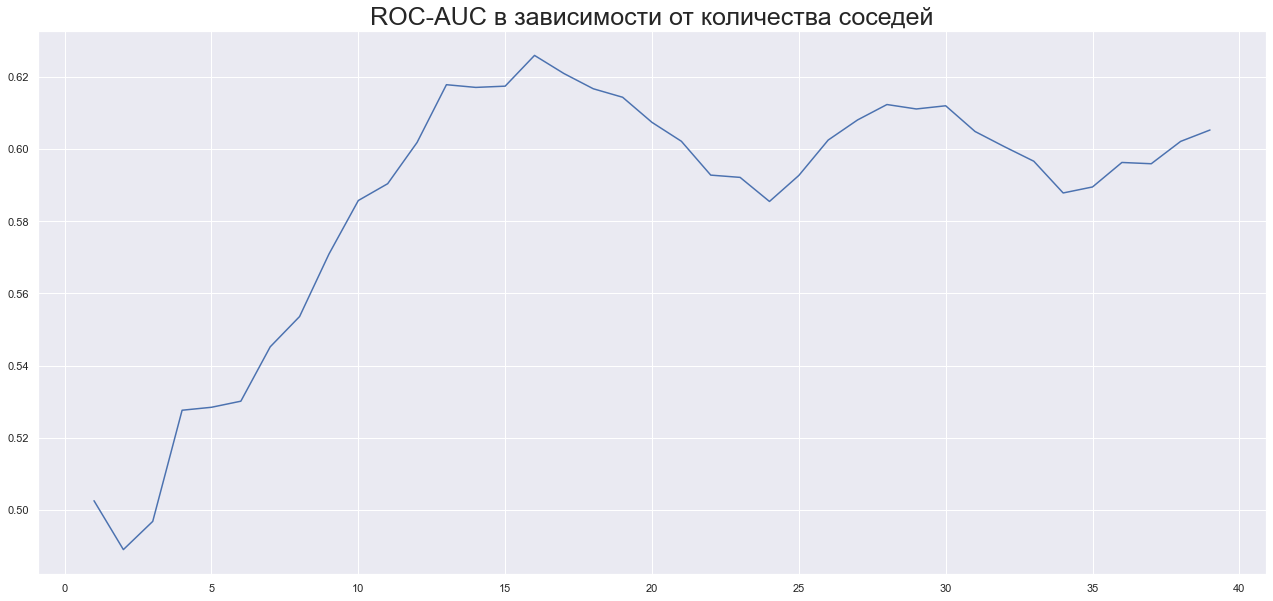

In [286]:
auc = []
for i in range(1, 40):
    y_p = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train).predict_proba(x_test)[:, 1]
    roc = roc_auc_score(y_test, y_p)
    auc.append(roc)
    print(f"k = {i}; roc-auc = {roc:.3f}")
sns.lineplot(x=list(range(1, 40)), y=auc).set_title('ROC-AUC в зависимости от количества соседей', fontdict={'size': 25});

__Имеем максимальный ROC-AUC равный 0.626. Явно лучше, чем было, но хочется ещё лучше. Попробуем прогнать логистическую регрессию через гридсёрч:__

In [289]:
space = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : ['none', 'l1', 'l2', 'elasticnet'], 
          'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 100]}
search = GridSearchCV(LogisticRegression(), space, scoring='roc_auc', n_jobs=-1, cv=4)
result = search.fit(x_train, y_train)
print(result.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [290]:
model_cool = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
model_cool.fit(x_train, y_train)
y_cool_pred = model_cool.predict_proba(x_test)[:, 1]

print('ROC-AUC score :', roc_auc_score(y_test, y_cool_pred))

ROC-AUC score : 0.5880483198015336


__ROC-AUC логистической регрессии всё равно 0.588, а жаль__

__Наша последняя надежда - случайный лес:__

In [291]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)
y_rf_pred = rf.predict_proba(x_test)[:, 1]

print('ROC-AUC score :', roc_auc_score(y_test, y_rf_pred))

ROC-AUC score : 0.6388137122237257


__Ура-ура, случайный лес побеждает! ROC-AUC 0.639, неплохо. Смотрим на количество деревьев и выясняем, можно ли ещё лучше (при условии, что нам не очень хочется ждать обучения полдня)__

k = 100; roc-auc = 0.595
k = 200; roc-auc = 0.608
k = 300; roc-auc = 0.627
k = 400; roc-auc = 0.637
k = 500; roc-auc = 0.629
k = 600; roc-auc = 0.631
k = 700; roc-auc = 0.639
k = 800; roc-auc = 0.637
k = 900; roc-auc = 0.622
k = 1000; roc-auc = 0.645
k = 1100; roc-auc = 0.617
k = 1200; roc-auc = 0.622
k = 1300; roc-auc = 0.625
k = 1400; roc-auc = 0.626
k = 1500; roc-auc = 0.637


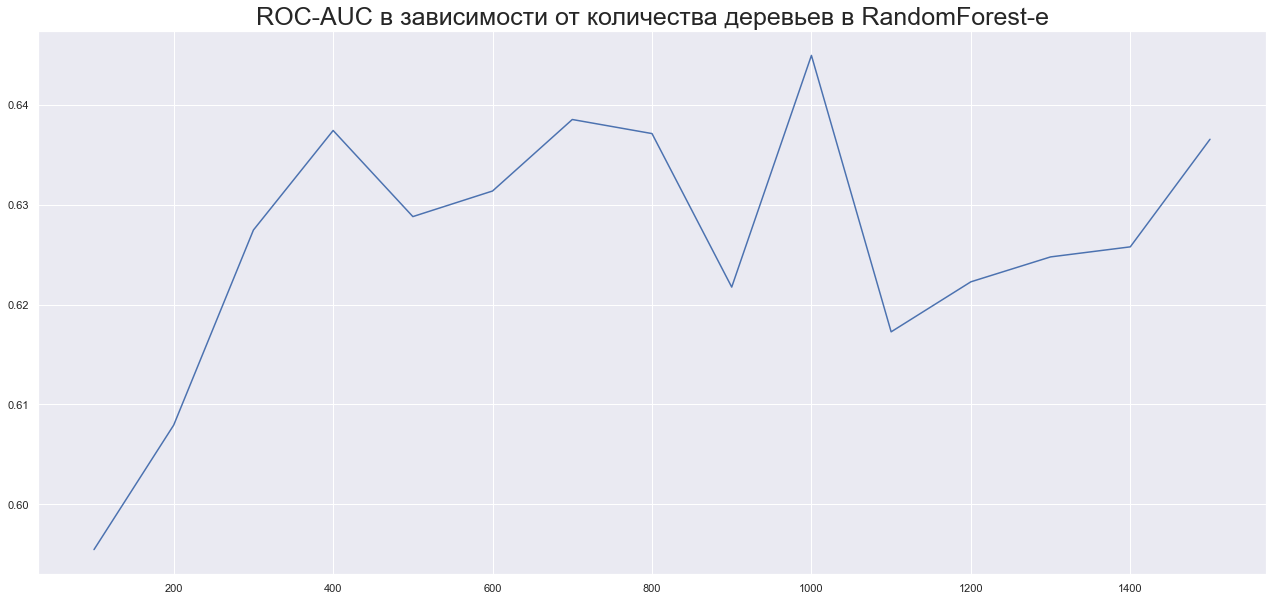

In [296]:
ra = []
for k in range(100, 1501, 100):
    y_rf = RandomForestClassifier(n_estimators=k).fit(x_train, y_train).predict_proba(x_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_rf)
    ra.append(roc_auc)
    print(f"k = {k}; roc-auc = {roc_auc:.3f}")
sns.lineplot(x=list(range(100, 1501, 100)), y=ra).set_title('ROC-AUC в зависимости от количества деревьев в RandomForest-e', fontdict={'size': 25});

__Пока что наш абсолютный победитель - случайный лес с максимальным ROC-AUC 0.645. Ну, неплохо, конечно...__

__Выходит, что наша модель верно упорядочила долю в 0.645 из всех пар нулей и единичек, предсказывает она лучше, чем случайный классификатор__